In [202]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


In [203]:
#leer csv

ruta_datos = "/content/forecast_data.csv"
data = pd.read_csv(ruta_datos)

#Preprocesado de values


values = data['value'].values.reshape(-1, 1)
value_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = value_scaler.fit_transform(values)

In [204]:
#Preprocesado de dates

data['date'] = pd.to_datetime(data['date'])
dates = data['date']

timpe_stamps = data.date.astype('int64').values.reshape(-1, 1)

date_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dates = date_scaler.fit_transform(timpe_stamps)

In [205]:
#generacion de matrices de entrenamiento

X = scaled_dates
y = scaled_values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Configuración del modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Capa de salida para un único valor de predicción
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2258 - mae: 0.4202 - val_loss: 0.1065 - val_mae: 0.2648
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1043 - mae: 0.2574 - val_loss: 0.0923 - val_mae: 0.2456
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0972 - mae: 0.2538 - val_loss: 0.0703 - val_mae: 0.2165
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0670 - mae: 0.2126 - val_loss: 0.0546 - val_mae: 0.1915
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0502 - mae: 0.1843 - val_loss: 0.0403 - val_mae: 0.1663
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0348 - mae: 0.1540 - val_loss: 0.0284 - val_mae: 0.1373
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - mae: 0.1337 - val_loss: 0.0228 - val_mae: 0.1224
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - mae: 0.1176 - val_loss: 0.0219 - val_mae: 0.1195
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202 - mae: 0.1148 - v

In [207]:
# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on Test Data: {mae}")

Mean Absolute Error on Test Data: 0.12110064923763275


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


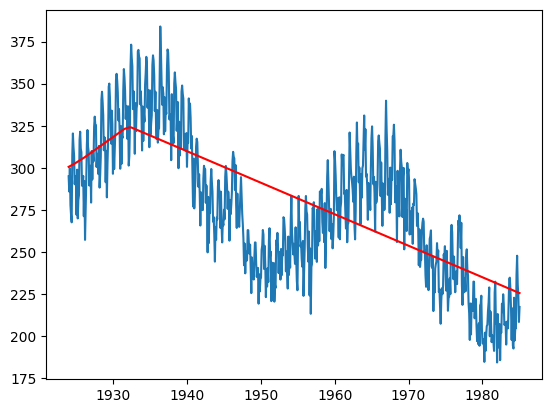

In [208]:
x_original = dates.values
y_original = values

plt.plot(x_original, y_original)
plt.plot(x_original, value_scaler.inverse_transform(model.predict(X)), "r")


In [209]:
def create_sequences(x, y, n_steps):
    sequences = []
    targets = []
    for i in range(len(data) - n_steps):
        seq = x[i:i + n_steps]
        target = y[i + n_steps]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Parámetro de longitud de la secuencia (ajusta según tus datos)
n_steps = 10  # Secuencia de 10 pasos para predecir el siguiente

# Crear secuencias para X y y
X_sequences, y_sequences = create_sequences(scaled_dates, scaled_values, n_steps)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=0
)

# Ajustar la forma para LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [222]:
# Crear el modelo LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, 1)),  # Primera capa LSTM
    Dropout(0.2),  # Regularización
    LSTM(32, return_sequences=False),  # Segunda capa LSTM
    Dense(16, activation='relu'),  # Capa densa para procesar las características
    Dense(1)  # Salida para predecir un único valor
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=2
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 - 5s - 141ms/step - loss: 0.1290 - mae: 0.2929 - val_loss: 0.0450 - val_mae: 0.1725
Epoch 2/50
37/37 - 1s - 23ms/step - loss: 0.0359 - mae: 0.1551 - val_loss: 0.0197 - val_mae: 0.1137
Epoch 3/50
37/37 - 0s - 11ms/step - loss: 0.0265 - mae: 0.1344 - val_loss: 0.0181 - val_mae: 0.1072
Epoch 4/50
37/37 - 0s - 12ms/step - loss: 0.0257 - mae: 0.1323 - val_loss: 0.0182 - val_mae: 0.1076
Epoch 5/50
37/37 - 0s - 11ms/step - loss: 0.0252 - mae: 0.1323 - val_loss: 0.0206 - val_mae: 0.1147
Epoch 6/50
37/37 - 1s - 17ms/step - loss: 0.0238 - mae: 0.1273 - val_loss: 0.0175 - val_mae: 0.1053
Epoch 7/50
37/37 - 1s - 17ms/step - loss: 0.0244 - mae: 0.1297 - val_loss: 0.0170 - val_mae: 0.1037
Epoch 8/50
37/37 - 0s - 12ms/step - loss: 0.0233 - mae: 0.1251 - val_loss: 0.0168 - val_mae: 0.1034
Epoch 9/50
37/37 - 0s - 12ms/step - loss: 0.0230 - mae: 0.1256 - val_loss: 0.0165 - val_mae: 0.1013
Epoch 10/50
37/37 - 0s - 12ms/step - loss: 0.0235 - mae: 0.1279 - val_loss: 0.0165 - val_mae: 0.102

In [223]:
import pandas as pd

# Generar la secuencia de fechas desde 1985-01-10 hasta 2024-01-01, cada primero de mes
start_date = "1985-01-10"
end_date = "2024-01-01"

# Generar las fechas usando pd.date_range
new_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
timpe_stamps = new_dates.astype('int64').values.reshape(-1, 1)
new_scaled_dates = date_scaler.transform(timpe_stamps)

In [224]:
new_dates

DatetimeIndex(['1985-01-31', '1985-02-28', '1985-03-31', '1985-04-30',
               '1985-05-31', '1985-06-30', '1985-07-31', '1985-08-31',
               '1985-09-30', '1985-10-31',
               ...
               '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30',
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', length=468, freq='ME')

In [225]:
def create_sequences(scaled_dates, n_steps):
    sequences = []
    for i in range(len(scaled_dates) - n_steps):
        seq = scaled_dates[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

In [226]:
reshaped_new_scaled_dates = create_sequences(new_scaled_dates, n_steps)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


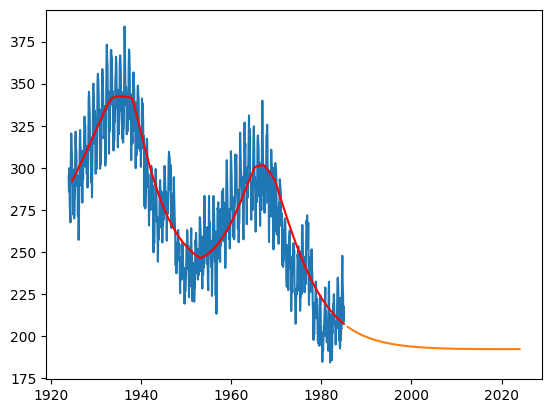

In [227]:
plt.plot(x_original, y_original)
plt.plot(x_original[n_steps:], value_scaler.inverse_transform(model.predict(X_sequences)), "r")
plt.plot(new_dates[n_steps:], value_scaler.inverse_transform(model.predict(reshaped_new_scaled_dates)))